In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import optuna
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score

import warnings
from optuna.logging import set_verbosity
from sklearn.preprocessing import StandardScaler


/home/kokodrillo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv('mai-ml-lab-2/train.csv')
test_df = pd.read_csv('mai-ml-lab-2/test.csv')

# Вспомогательные функции


In [3]:
sns.set(style="whitegrid")

def show_dependency(df, xcol, ycol):
    plt.figure(figsize=(10, 6))
    sns.regplot(x=xcol, y=ycol, data=df, scatter=True, line_kws={"color": "red"})
    plt.title(f'Зависимость между {xcol} и {ycol}')
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.show()


def plot_distributions(df, cols=None, kind='hist'):
    if cols is None:
        cols = df.select_dtypes(include=['number']).columns

    num_plots = len(cols)
    plt.figure(figsize=(12, num_plots * 4))

    for i, col in enumerate(cols, 1):
        plt.subplot(num_plots, 1, i)
        if kind == 'hist':
            sns.histplot(df[col], kde=True, bins=30, color='skyblue')
            plt.title(f'Гистограмма распределения {col}')
        elif kind == 'kde':
            sns.kdeplot(df[col], shade=True, color='purple')
            plt.title(f'KDE распределение {col}')
        elif kind == 'box':
            sns.boxplot(x=df[col], color='orange')
            plt.title(f'Box Plot распределения {col}')
        else:
            raise ValueError(f"Неизвестный тип графика: {kind}")

        plt.xlabel(col)
        plt.ylabel('Частота')

    plt.tight_layout()
    plt.show()

def show_real_and_predicted(y_test, y_pred):
    plt.figure(figsize=(10, 7))
    plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Предсказания')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Идеал')
    plt.xlabel('Реальные значения')
    plt.ylabel('Предсказанные значения')
    plt.title('Сравнение реальных и предсказанных значений RiskScore')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Разведочный анализ данных

In [4]:
print(train_df.head())
print(test_df.head())


   id   age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0   0  55.0       150.0        50.0       73.0             0.8   
1   1  50.0       160.0        60.0       79.6             1.0   
2   2  55.0       145.0        50.0       73.0             1.2   
3   3  40.0       175.0        80.0       83.2             0.9   
4   4  30.0       170.0        70.0       79.5             1.2   

   eyesight(right)  hearing(left)  hearing(right)  systolic  ...   HDL    LDL  \
0              1.0            1.0             1.0     122.0  ...  62.0  113.0   
1              0.8            1.0             1.0     124.0  ...  74.0  112.0   
2              1.2            1.0             1.0     110.0  ...  66.0  123.0   
3              1.0            1.0             1.0      99.0  ...  38.0  114.0   
4              1.2            1.0             1.0     119.0  ...  49.0  148.0   

   hemoglobin  Urine protein  serum creatinine   AST   ALT   Gtp  \
0        12.0            1.0               0.6  

In [5]:
display(train_df.info())
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  int64  
 1   age                  15000 non-null  float64
 2   height(cm)           15000 non-null  float64
 3   weight(kg)           15000 non-null  float64
 4   waist(cm)            15000 non-null  float64
 5   eyesight(left)       15000 non-null  float64
 6   eyesight(right)      15000 non-null  float64
 7   hearing(left)        15000 non-null  float64
 8   hearing(right)       15000 non-null  float64
 9   systolic             15000 non-null  float64
 10  relaxation           15000 non-null  float64
 11  fasting blood sugar  15000 non-null  float64
 12  Cholesterol          15000 non-null  float64
 13  triglyceride         15000 non-null  float64
 14  HDL                  15000 non-null  float64
 15  LDL                  15000 non-null 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   height(cm)           10000 non-null  float64
 3   weight(kg)           10000 non-null  float64
 4   waist(cm)            10000 non-null  float64
 5   eyesight(left)       10000 non-null  float64
 6   eyesight(right)      10000 non-null  float64
 7   hearing(left)        10000 non-null  float64
 8   hearing(right)       10000 non-null  float64
 9   systolic             10000 non-null  float64
 10  relaxation           10000 non-null  float64
 11  fasting blood sugar  10000 non-null  float64
 12  Cholesterol          10000 non-null  float64
 13  triglyceride         10000 non-null  float64
 14  HDL                  10000 non-null  float64
 15  LDL                  10000 non-null  

None

In [6]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64
id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL         

In [7]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

0
0


In [8]:
display(train_df.describe())
display(test_df.describe())

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,42.606000,164.672667,64.282000,80.323180,1.032727,1.025927,1.005533,1.004933,119.149467,...,57.535667,113.158533,14.510340,1.016533,0.866580,22.272667,20.874933,26.290200,0.139467,0.366600
std,4330.271354,10.415341,8.558684,10.973871,7.932701,0.312845,0.313488,0.074183,0.070067,11.167046,...,11.380739,18.442012,1.392921,0.157464,0.168492,6.324422,10.314009,20.431882,0.346444,0.481892
min,0.000000,20.000000,140.000000,35.000000,0.900000,0.100000,0.100000,1.000000,1.000000,82.000000,...,28.000000,41.000000,7.200000,1.000000,0.100000,9.000000,4.000000,6.000000,0.000000,0.000000
25%,3749.750000,40.000000,160.000000,55.000000,75.000000,0.800000,0.800000,1.000000,1.000000,110.000000,...,49.000000,100.000000,13.500000,1.000000,0.800000,18.000000,14.000000,15.000000,0.000000,0.000000
50%,7499.500000,40.000000,165.000000,65.000000,80.000000,1.000000,1.000000,1.000000,1.000000,119.000000,...,56.000000,112.000000,14.700000,1.000000,0.900000,21.000000,18.000000,21.000000,0.000000,0.000000
75%,11249.250000,50.000000,170.000000,70.000000,86.000000,1.200000,1.200000,1.000000,1.000000,128.000000,...,65.000000,126.000000,15.600000,1.000000,1.000000,25.000000,24.000000,31.000000,0.000000,1.000000
max,14999.000000,80.000000,190.000000,120.000000,121.000000,9.900000,9.900000,2.000000,2.000000,190.000000,...,105.000000,193.000000,28.900000,5.000000,1.600000,324.000000,190.000000,566.000000,1.000000,1.000000


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,19999.50000,42.690000,164.737500,64.343000,80.355780,1.033340,1.030660,1.005300,1.00580,118.995400,...,102.987800,57.250900,113.571700,14.544950,1.015900,0.868460,22.26470,20.991600,26.748300,0.143400
std,2886.89568,10.476873,8.574436,11.110612,7.995454,0.300535,0.301209,0.072612,0.07594,11.021276,...,48.720228,11.407908,18.540033,1.391966,0.156364,0.167678,5.91117,10.474517,20.230123,0.350498
min,15000.00000,20.000000,140.000000,40.000000,58.000000,0.100000,0.100000,1.000000,1.00000,82.000000,...,20.000000,27.000000,40.000000,5.900000,1.000000,0.100000,9.00000,5.000000,6.000000,0.000000
25%,17499.75000,40.000000,160.000000,55.000000,75.000000,0.800000,0.800000,1.000000,1.00000,110.000000,...,71.000000,49.000000,100.000000,13.500000,1.000000,0.800000,18.00000,14.000000,15.000000,0.000000
50%,19999.50000,40.000000,165.000000,65.000000,80.200000,1.000000,1.000000,1.000000,1.00000,119.000000,...,90.000000,56.000000,113.000000,14.700000,1.000000,0.900000,21.00000,18.000000,21.000000,0.000000
75%,22499.25000,50.000000,170.000000,70.000000,86.000000,1.200000,1.200000,1.000000,1.00000,127.250000,...,121.000000,65.000000,126.000000,15.600000,1.000000,1.000000,25.00000,25.000000,31.000000,0.000000
max,24999.00000,80.000000,185.000000,110.000000,114.000000,9.900000,9.900000,2.000000,2.00000,170.000000,...,397.000000,103.000000,187.000000,19.300000,4.000000,2.500000,117.00000,215.000000,568.000000,1.000000


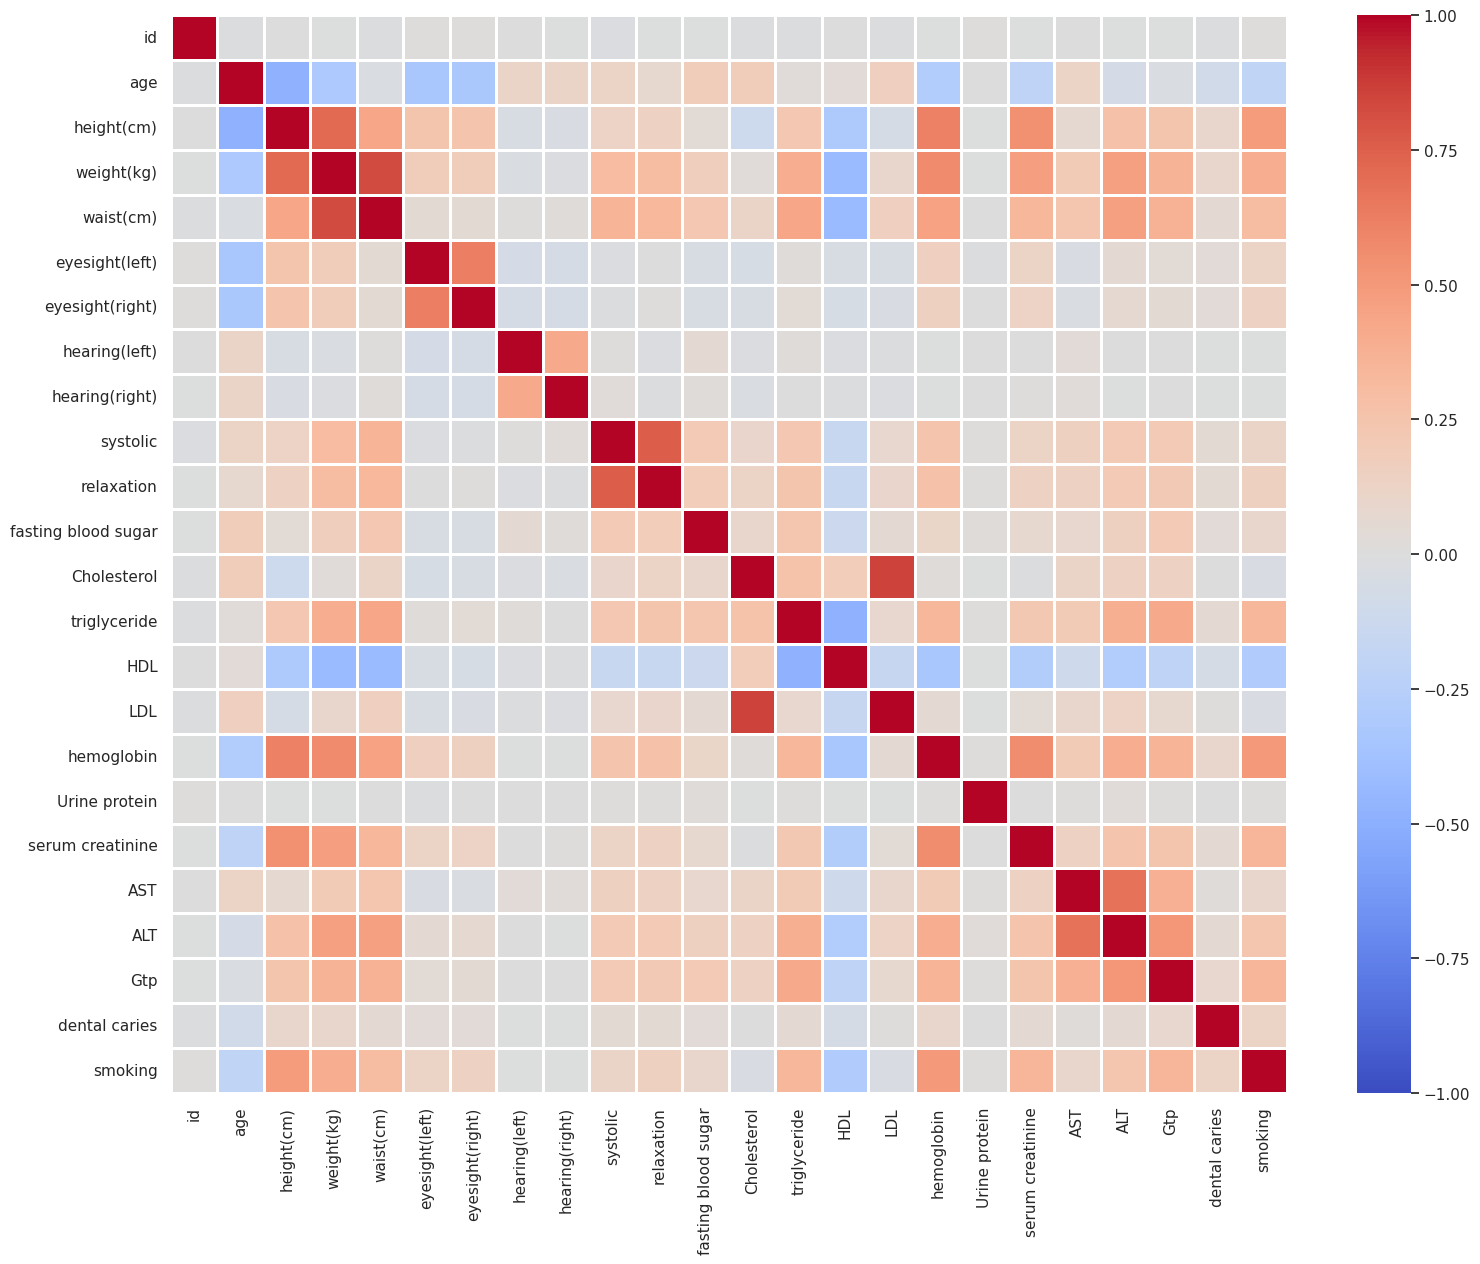

In [9]:
corr_matrix = train_df.corr()

plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix,
            # annot=True,
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            linewidths=1)
plt.show()

In [10]:
high_corr = corr_matrix[(abs(corr_matrix) >= 0.7) & (corr_matrix != 1.0)].stack()

low_corr = corr_matrix[(abs(corr_matrix) <= 0.1)].stack()
print(high_corr)
print(low_corr[::100])

height(cm)   weight(kg)     0.716334
weight(kg)   height(cm)     0.716334
             waist(cm)      0.826307
waist(cm)    weight(kg)     0.826307
systolic     relaxation     0.758938
relaxation   systolic       0.758938
Cholesterol  LDL            0.852157
LDL          Cholesterol    0.852157
dtype: float64
id             age            -0.007935
hearing(left)  hemoglobin     -0.000296
LDL            triglyceride    0.083153
smoking        Cholesterol    -0.035048
dtype: float64


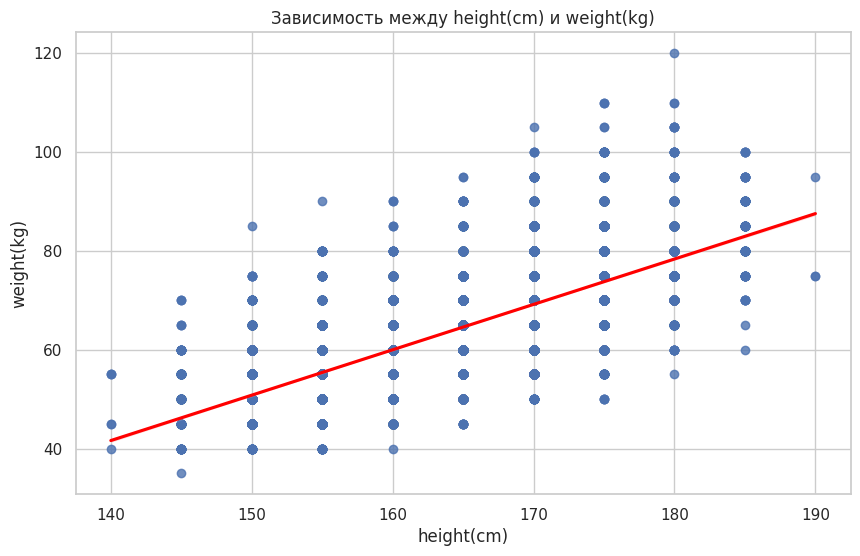

In [11]:
show_dependency(train_df, 'height(cm)', 'weight(kg)')

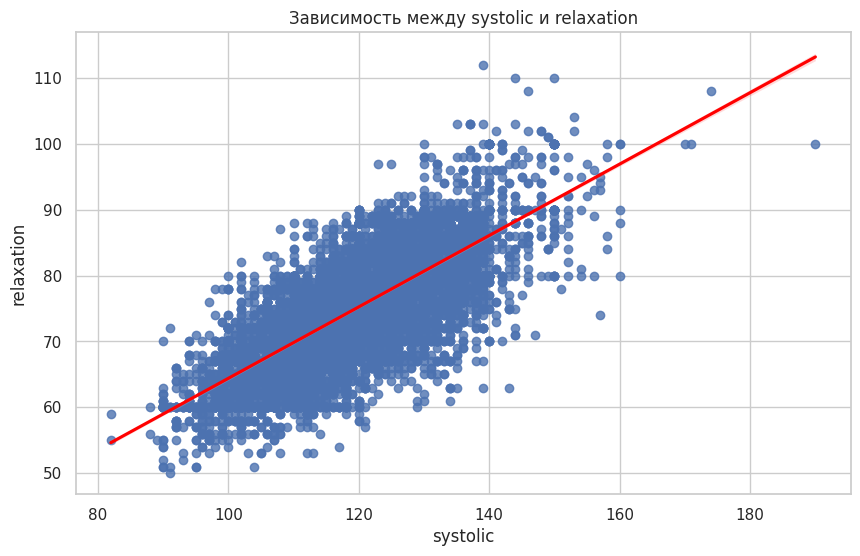

In [12]:
show_dependency(train_df, 'systolic', 'relaxation')

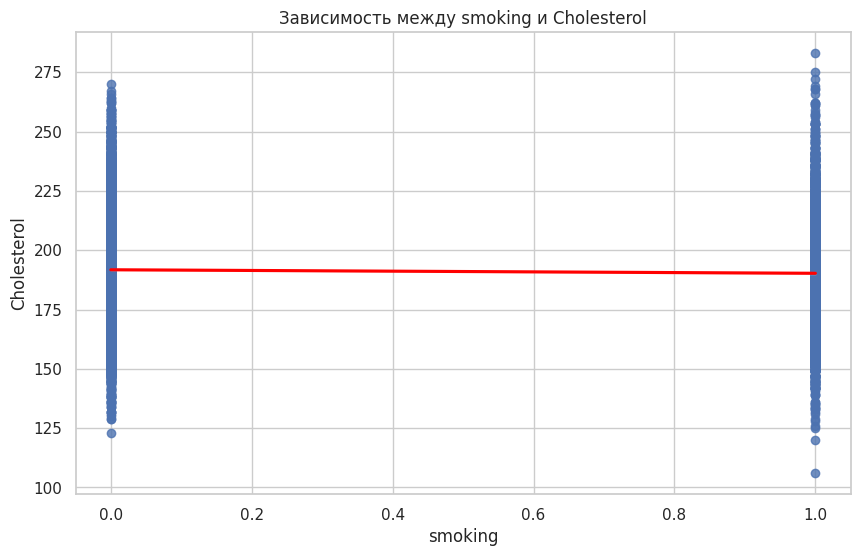

In [13]:
show_dependency(train_df, 'smoking', 'Cholesterol')

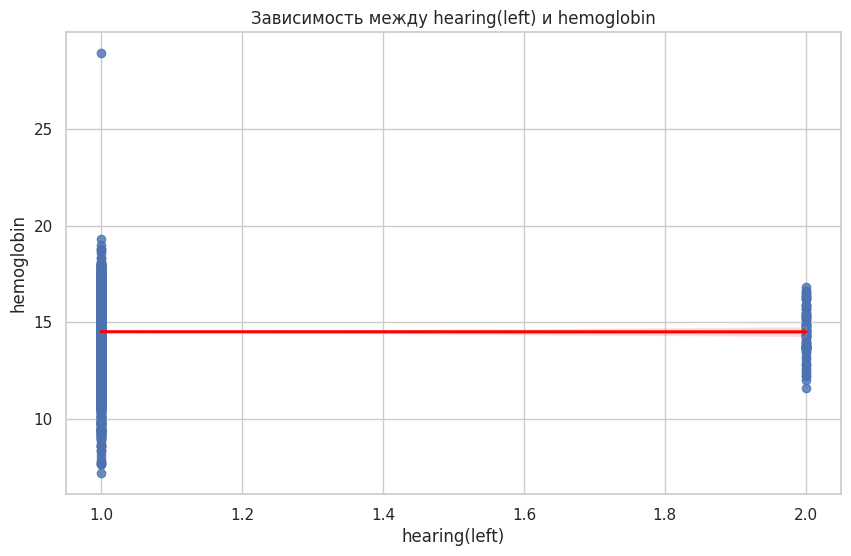

In [14]:
show_dependency(train_df, 'hearing(left)', 'hemoglobin')

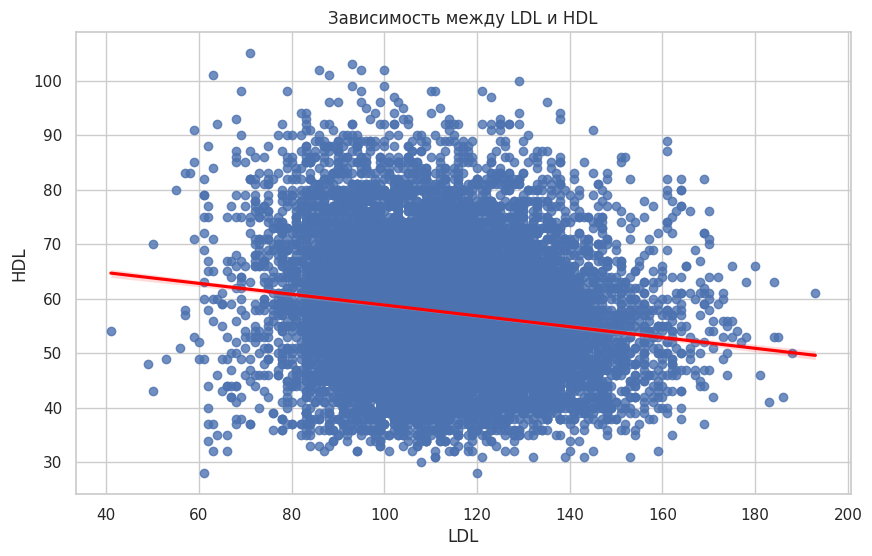

In [15]:
show_dependency(train_df, 'LDL', 'HDL')

In [16]:
train_df = train_df.drop(columns='id')

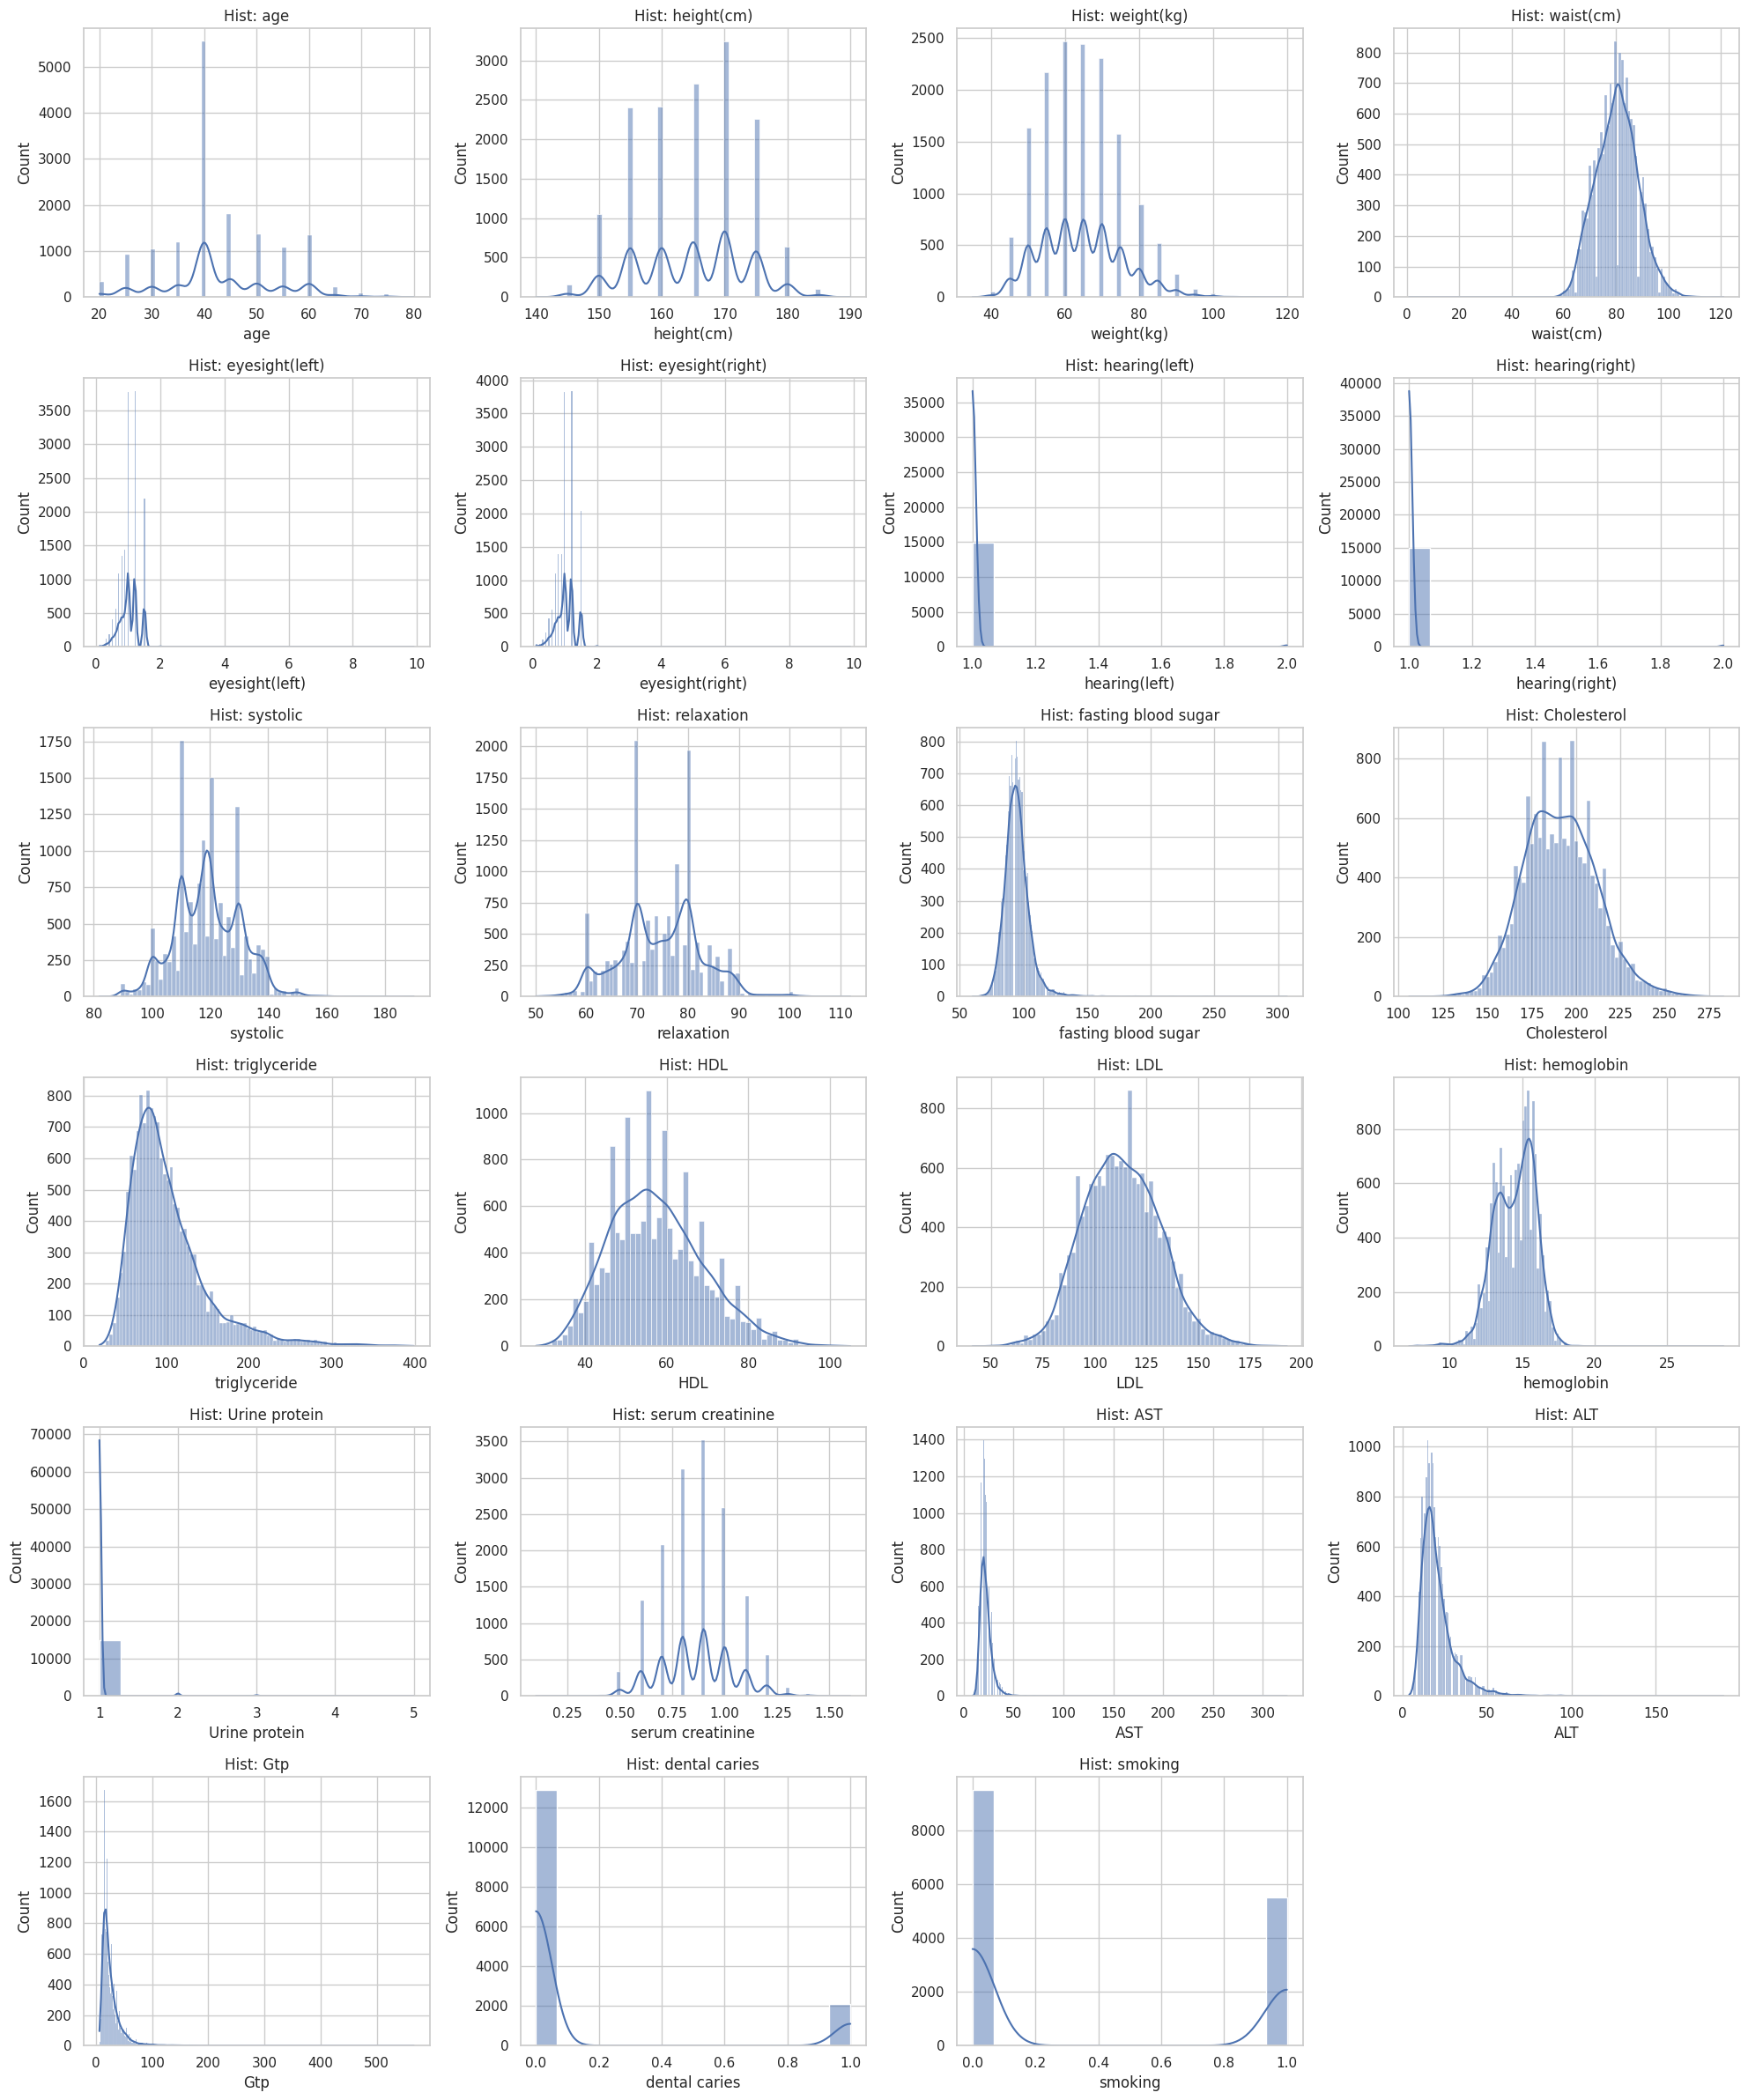

In [17]:
import math

def plot_feature_distributions(df, max_cols=4, figsize=(20, 4)):
    num_features = len(df.columns)
    n_cols = min(max_cols, num_features)
    n_rows = math.ceil(num_features / n_cols)

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows))
    
    for i, col in enumerate(df.columns):
        plt.subplot(n_rows, n_cols, i + 1)
        
        if pd.api.types.is_numeric_dtype(df[col]):
            sns.histplot(df[col].dropna(), kde=True)
            plt.title(f'Hist: {col}')
        else:
            df[col].value_counts().plot(kind='bar')
            plt.title(f'Bar: {col}')
        
        plt.tight_layout()
    
    plt.show()

plot_feature_distributions(train_df)

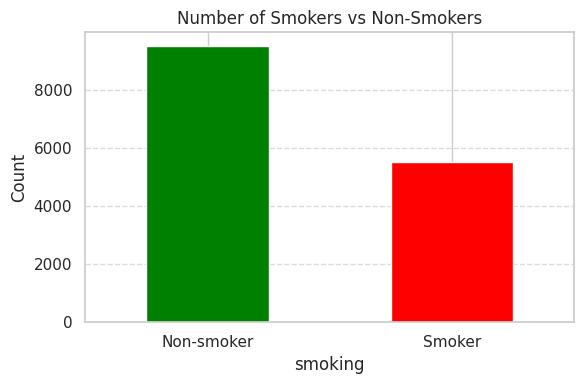

In [18]:
smoking_counts = train_df['smoking'].value_counts().sort_index()  # Предположим: 0 — некурящий, 1 — курящий

plt.figure(figsize=(6, 4))
smoking_counts.plot(kind='bar', color=['green', 'red'])
plt.xticks([0, 1], ['Non-smoker', 'Smoker'], rotation=0)
plt.ylabel('Count')
plt.title('Number of Smokers vs Non-Smokers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipykernel_79973/3103022212.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='smoking', y=col, palette='Set2')
/tmp/ipykernel_79973/3103022212.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='smoking', y=col, palette='Set2')
/tmp/ipykernel_79973/3103022212.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='smoking', y=col, palette='Set2')
/tmp/ipykernel_79973/3103022212.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0.

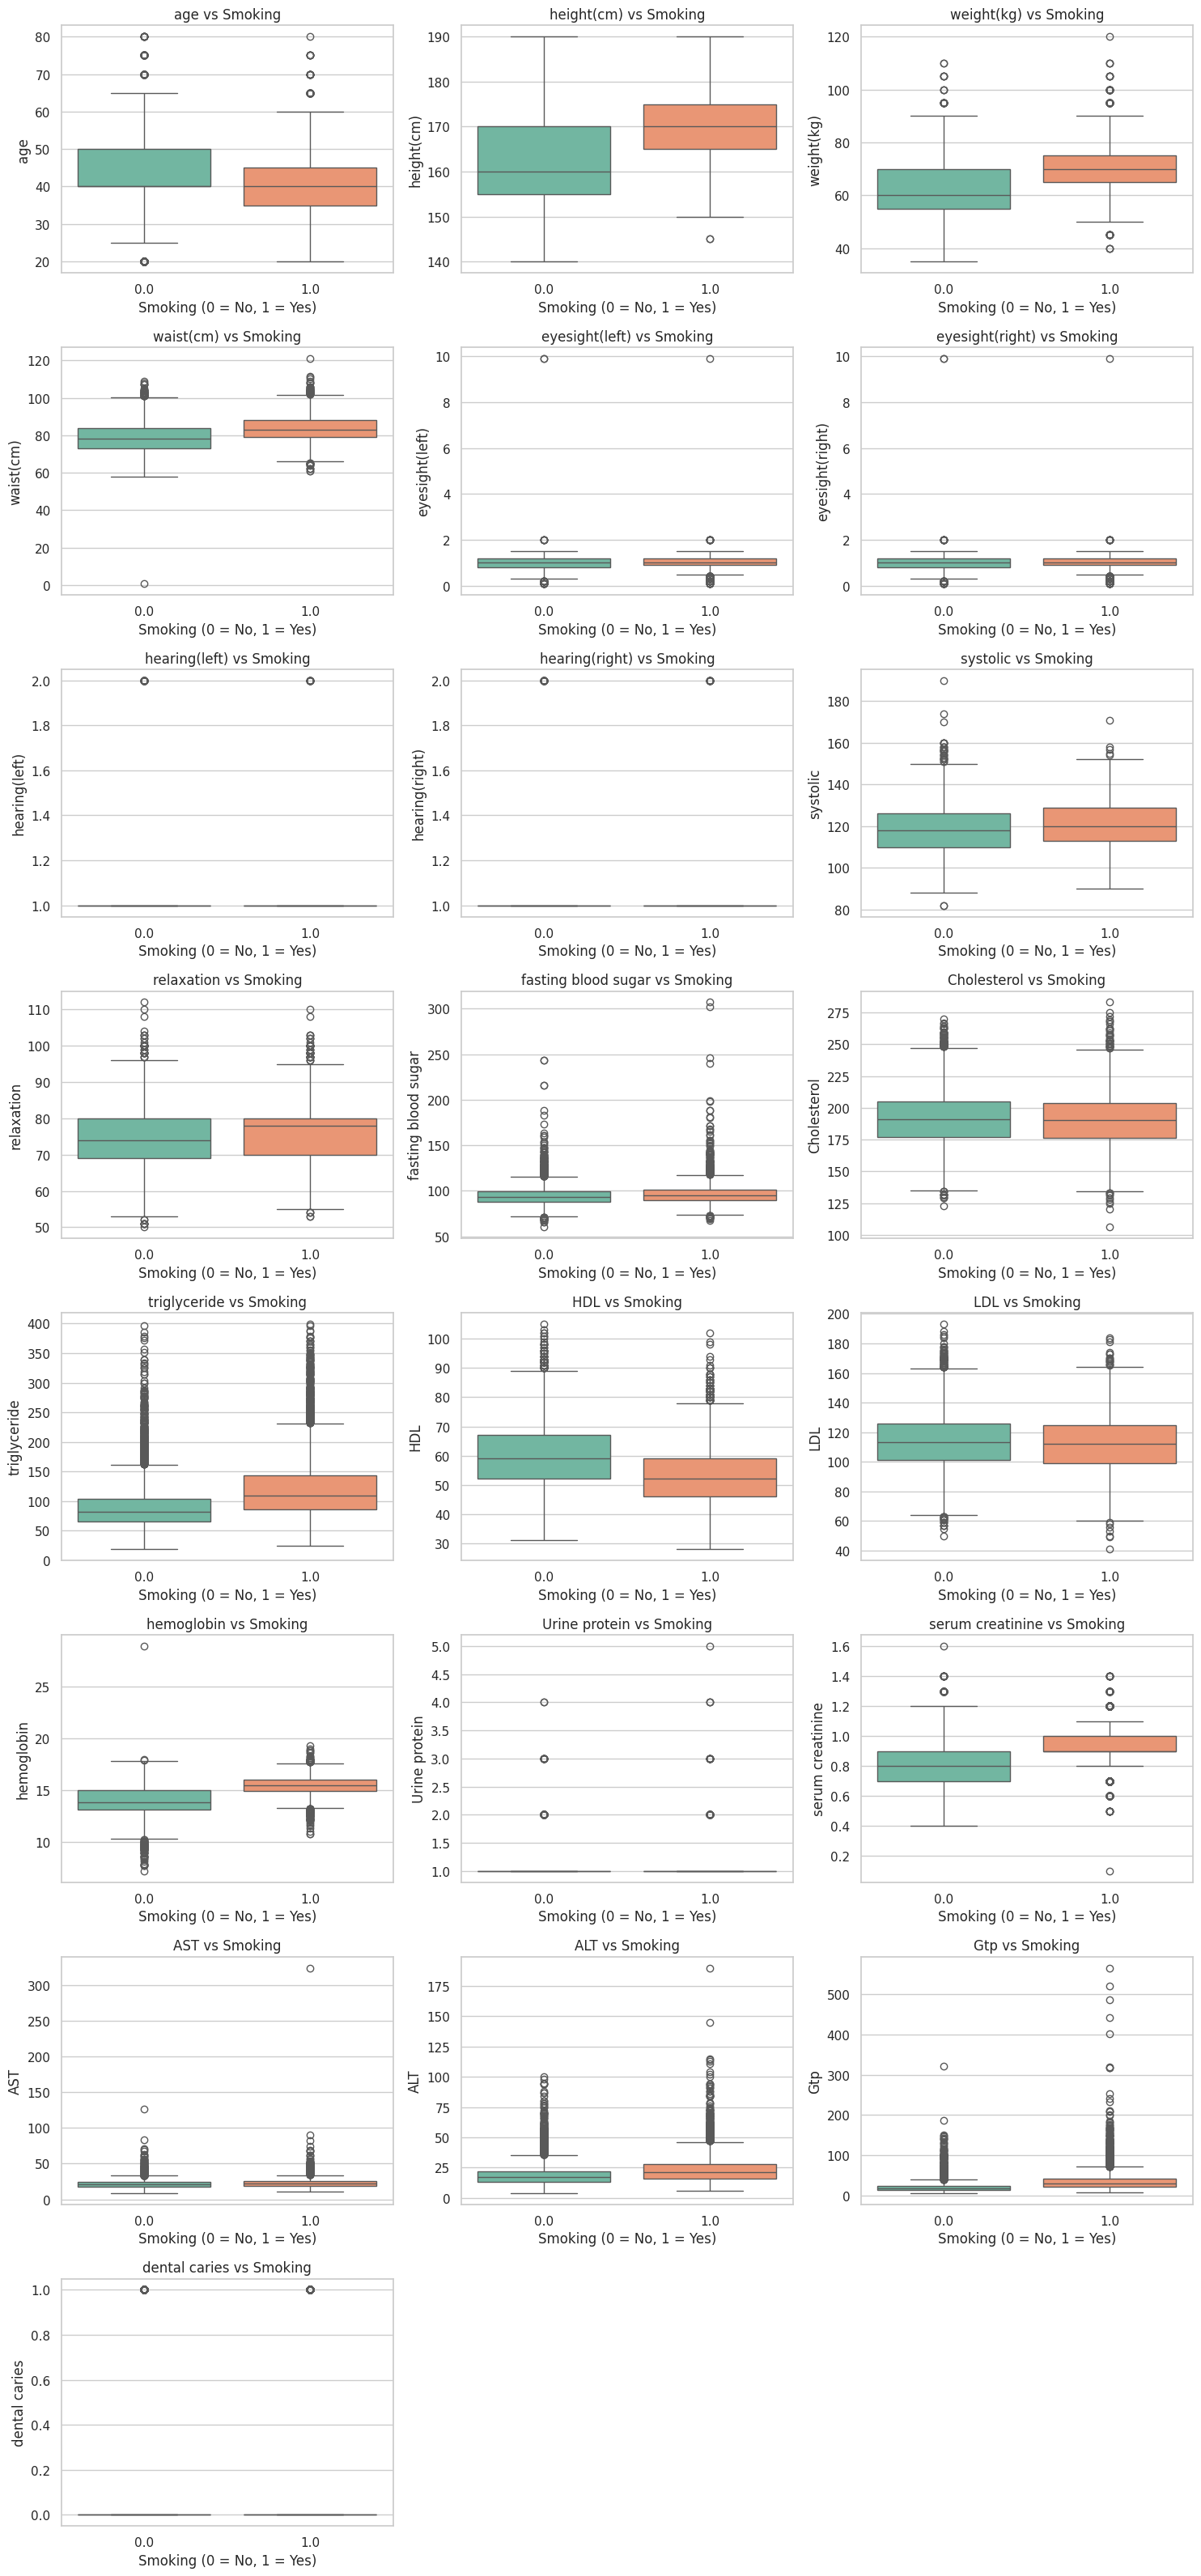

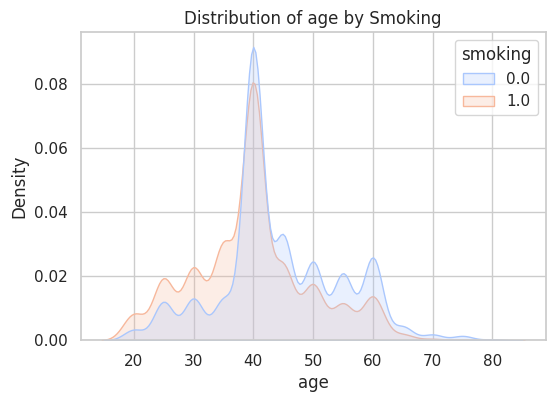

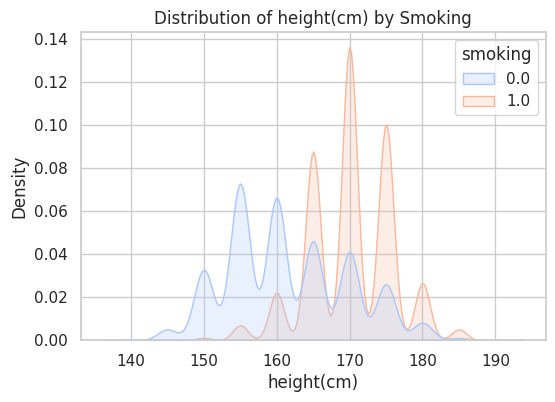

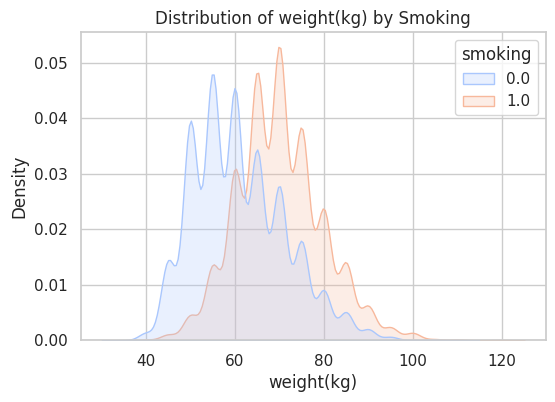

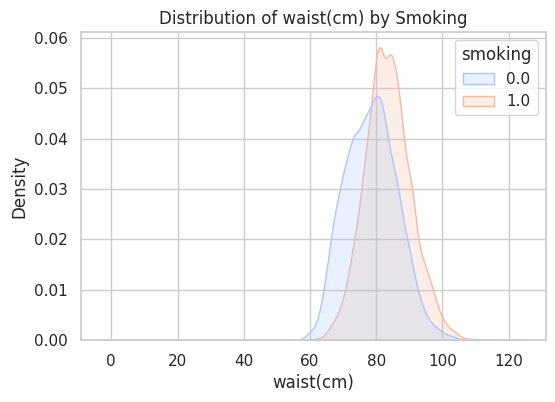

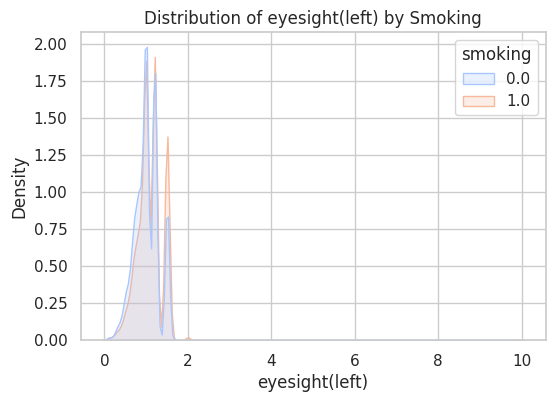

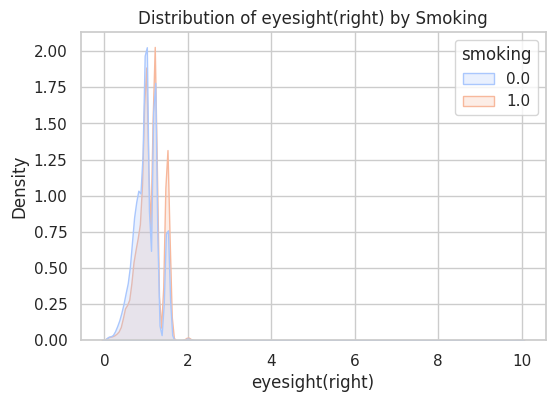

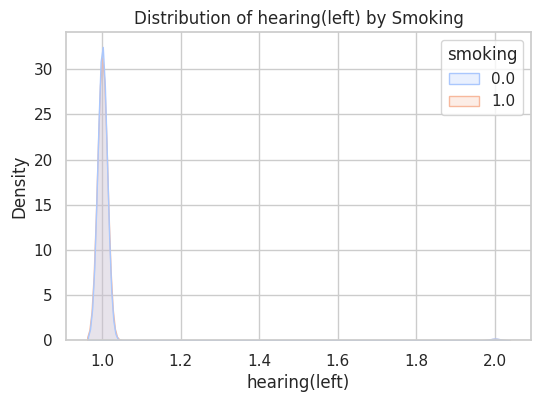

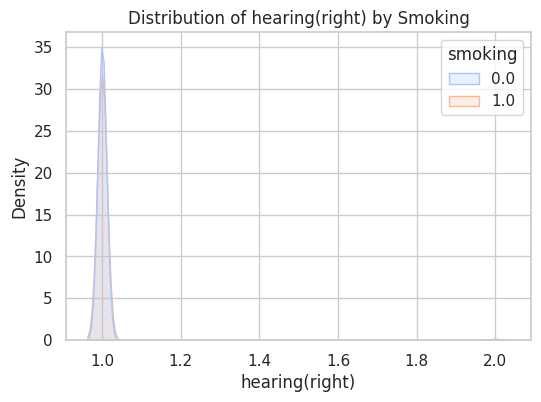

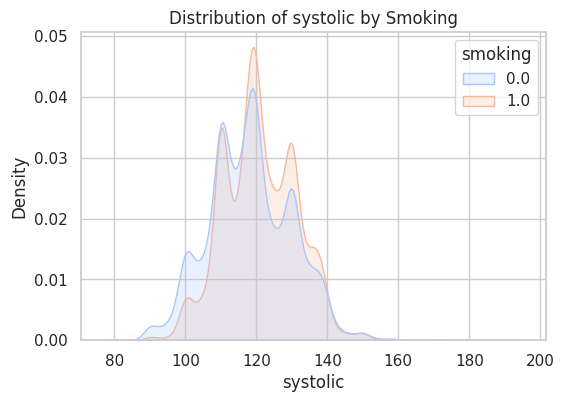

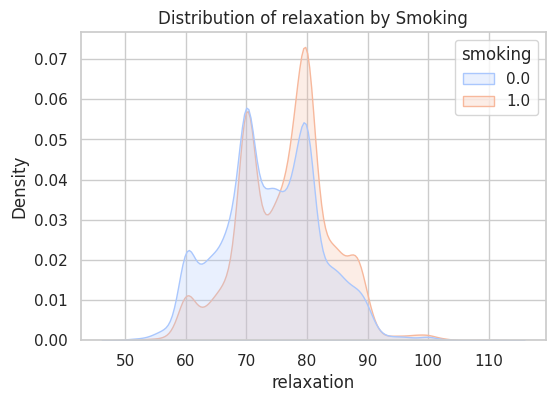

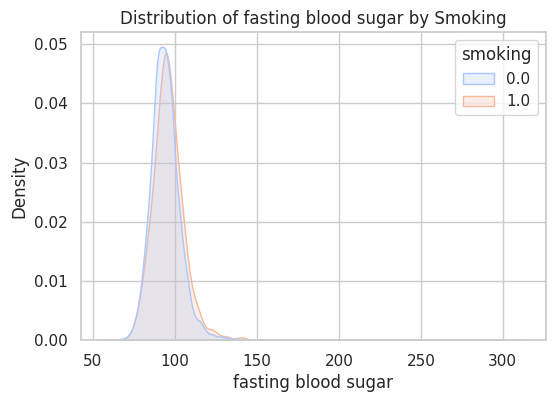

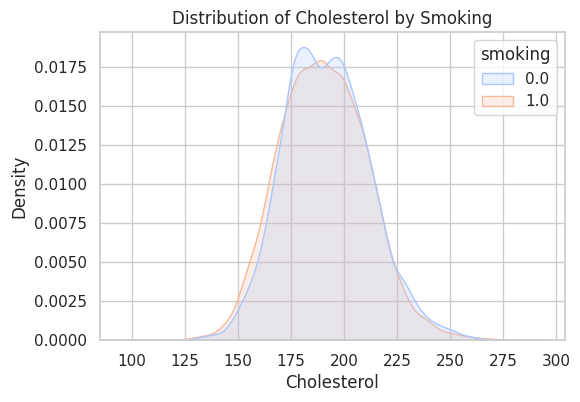

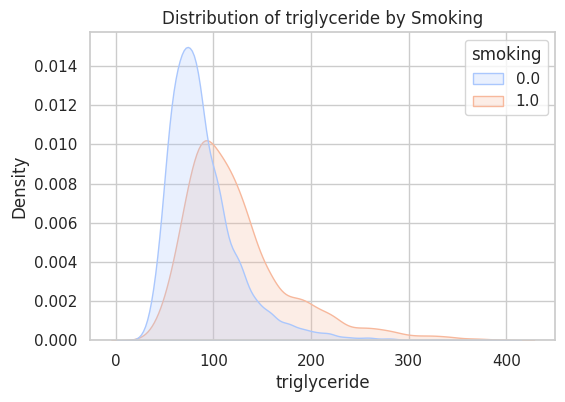

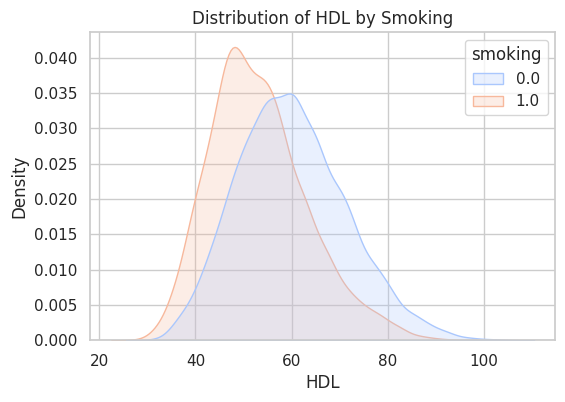

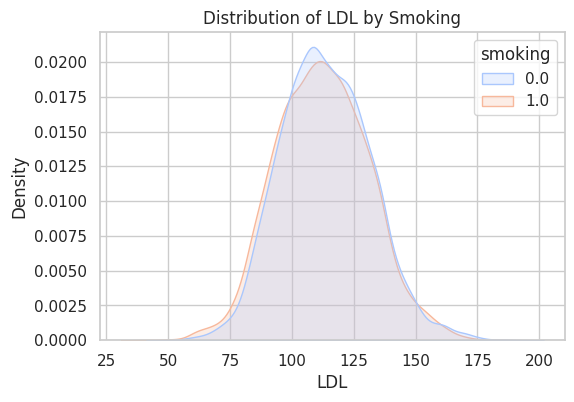

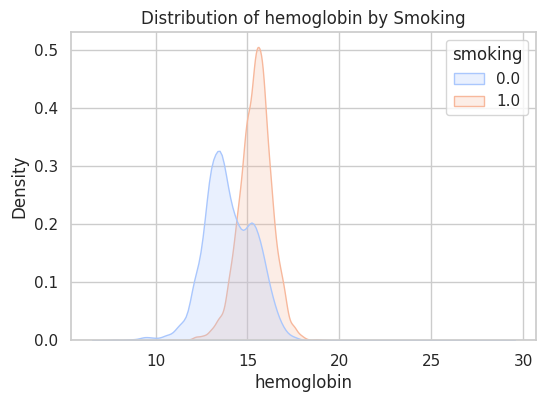

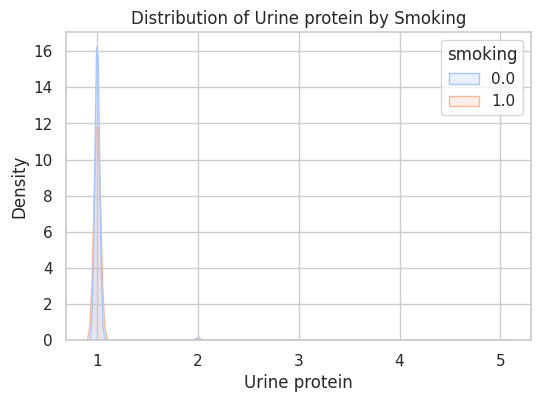

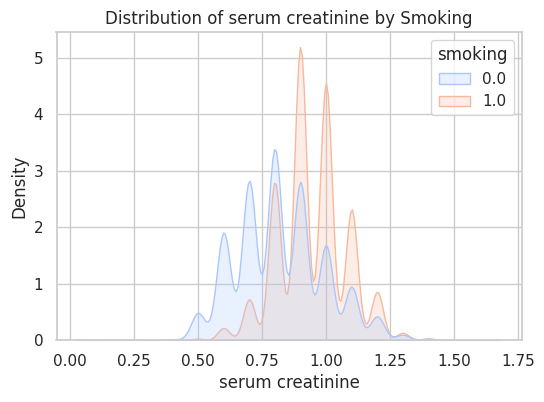

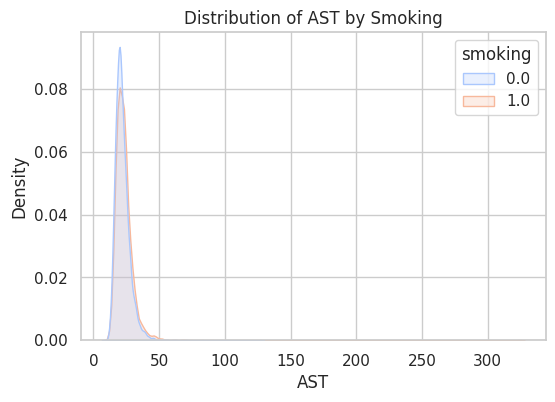

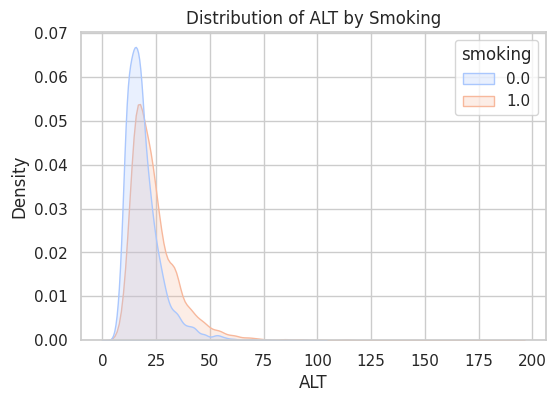

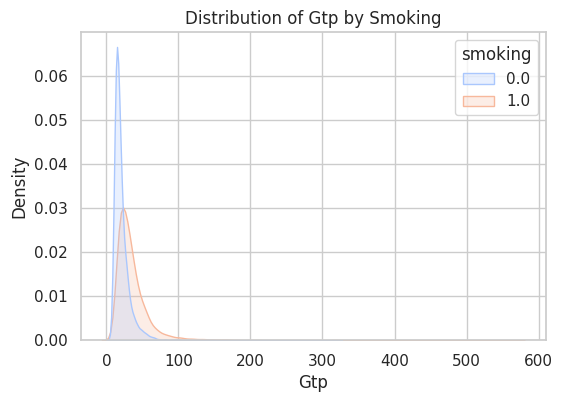

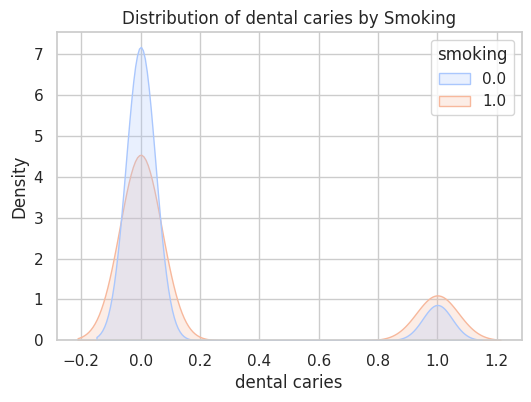

In [19]:
features = train_df.drop(columns=['smoking']).select_dtypes(include='number').columns

n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))
for i, col in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=train_df, x='smoking', y=col, palette='Set2')
    plt.title(f'{col} vs Smoking')
    plt.xlabel('Smoking (0 = No, 1 = Yes)')
    plt.tight_layout()
plt.show()

for col in features:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=train_df, x=col, hue='smoking', fill=True, common_norm=False, palette='coolwarm')
    plt.title(f'Distribution of {col} by Smoking')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

Вывод: данные неплохо подходят для обучения моделей: сильно коррелирующих признаков почти нет, нет null и дубликатов. Однако в выборке некурящих представлено значительно больше, чем курящих, что негативно может повлиять на результат обучения

# Бэггинг

In [20]:
import numpy as np
from sklearn.base import clone
from collections import Counter

class MyBagging:
    def __init__(self, base_model, n_estimators=10, random_state=None):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.models = []
        self.random_state = random_state

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.models = []

        for _ in range(self.n_estimators):
            indices = np.random.choice(len(X), len(X), replace=True)
            X_sample = X.iloc[indices]
            y_sample = y.iloc[indices]

            
            model = clone(self.base_model)
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def predict_proba(self, X):
        probas = [model.predict_proba(X) for model in self.models]
        return np.mean(probas, axis=0)

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        
        if np.issubdtype(predictions.dtype, np.integer):
            final_preds = [Counter(row).most_common(1)[0][0] for row in predictions.T]
        else:
            final_preds = [Counter(row.astype(int)).most_common(1)[0][0] for row in predictions.T]
        
        return np.array(final_preds)



In [21]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import BaggingClassifier

X = train_df.drop(['smoking'], axis=1)
y = train_df['smoking']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_df

base_model = DecisionTreeClassifier(max_depth=3, random_state=42)

my_bagging = MyBagging(base_model=base_model, n_estimators=100, random_state=42)
my_bagging.fit(X_train, y_train)
my_prob = my_bagging.predict_proba(X_val)[:, 1]

sklearn_bagging = BaggingClassifier(base_model, n_estimators=100, random_state=42)
sklearn_bagging.fit(X_train, y_train)
sklearn_proba = sklearn_bagging.predict_proba(X_val)[:, 1]

single_tree = clone(base_model)
single_tree.fit(X_train, y_train)
tree_proba = single_tree.predict_proba(X_val)[:, 1]

my_auc = roc_auc_score(y_val, my_prob)
sklearn_auc = roc_auc_score(y_val, sklearn_proba)
tree_auc = roc_auc_score(y_val, tree_proba)

print(f"ROC-AUC scores:")
print(f"Single Tree: {tree_auc:.6f}")
print(f"My Bagging: {my_auc:.6f}")
print(f"Sklearn Bagging: {sklearn_auc:.6f}")



ROC-AUC scores:
Single Tree: 0.839203
My Bagging: 0.857006
Sklearn Bagging: 0.857816


# Бустинг

In [22]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from scipy.special import expit

class SimpleGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.F0 = None

    def fit(self, X, y):
        p = np.mean(y)
        self.F0 = np.log(p / (1 - p))
        Fm = np.full(y.shape, self.F0)

        for _ in range(self.n_estimators):
            p = expit(Fm)
            residual = y - p 
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residual)
            update = tree.predict(X)
            Fm += self.learning_rate * update
            self.trees.append(tree)

    def predict_proba(self, X):
        Fm = np.full((X.shape[0],), self.F0)
        for tree in self.trees:
            Fm += self.learning_rate * tree.predict(X)
        p = expit(Fm)
        return np.vstack([1 - p, p]).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

X = train_df.drop(columns=["smoking"]).values
y = train_df["smoking"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SimpleGradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Accuracy: 0.7873333333333333
ROC AUC: 0.869990567817393


In [24]:
from sklearn.ensemble import GradientBoostingClassifier

sk_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
sk_model.fit(X_train, y_train)
sk_pred = sk_model.predict(X_test)
sk_proba = sk_model.predict_proba(X_test)[:, 1]

print("Sklearn Accuracy:", accuracy_score(y_test, sk_pred))
print("Sklearn ROC AUC:", roc_auc_score(y_test, sk_proba))


Sklearn Accuracy: 0.8093333333333333
Sklearn ROC AUC: 0.8897972080739482


# Сравнение результатов работы алгоритмов градиентного бустинга.

In [25]:
X = train_df.drop(columns=["smoking"])
y = train_df["smoking"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sk_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
sk_model.fit(X_train, y_train)
sk_pred = sk_model.predict(X_test)
sk_proba = sk_model.predict_proba(X_test)[:, 1]

lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
lgb_proba = lgb_model.predict_proba(X_test)[:, 1]

xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

cat_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3, verbose=0, random_seed=42)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)
cat_proba = cat_model.predict_proba(X_test)[:, 1]

def print_scores(name, y_true, y_pred, y_proba):
    print(f"{name} Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"{name} ROC AUC: {roc_auc_score(y_true, y_proba):.4f}")
    print()

print_scores("Sklearn GB", y_test, sk_pred, sk_proba)
print_scores("LightGBM", y_test, lgb_pred, lgb_proba)
print_scores("XGBoost", y_test, xgb_pred, xgb_proba)
print_scores("CatBoost", y_test, cat_pred, cat_proba)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4359, number of negative: 7641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.363250 -> initscore=-0.561286
[LightGBM] [Info] Start training from score -0.561286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/home/kokodrillo/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:32:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Sklearn GB Accuracy: 0.8093
Sklearn GB ROC AUC: 0.8898

LightGBM Accuracy: 0.8073
LightGBM ROC AUC: 0.8899

XGBoost Accuracy: 0.8103
XGBoost ROC AUC: 0.8903

CatBoost Accuracy: 0.8027
CatBoost ROC AUC: 0.8878



Лучшая модель- XGBoost

# Подборка оптимальных параметров для XGBoostClassifier

In [26]:

def objective(trial):
    config = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "random_state": 27,
        "eval_metric": "auc",
        "n_jobs": -1,
        "use_label_encoder": False
    }

    booster = xgb.XGBClassifier(**config)
    booster.fit(X_train, y_train)
    probas = booster.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, probas)


set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_config = study.best_params
print("\nПодобранные параметры:")
print(pd.DataFrame(best_config.items(), columns=["Гиперпараметр", "Значение"]))

final_model = xgb.XGBClassifier(
    **best_config,
    use_label_encoder=False,
    eval_metric="auc",
    random_state=27,
    n_jobs=-1
)

final_model.fit(X_train, y_train)
final_probs = final_model.predict_proba(X_val)[:, 1]
final_auc = roc_auc_score(y_val, final_probs)

print(f"\nФинальный ROC-AUC: {final_auc:.6f}")


Подобранные параметры:
      Гиперпараметр    Значение
0      n_estimators  444.000000
1         max_depth    5.000000
2     learning_rate    0.090493
3         subsample    0.897716
4  colsample_bytree    0.714747
5             gamma    2.046560
6         reg_alpha    3.129086
7        reg_lambda    2.344602

Финальный ROC-AUC: 0.896253


# Финальное предсказание

In [27]:

X_test = test_df.drop(columns=["id"], errors="ignore")

test_proba = final_model.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    "id": test_df["id"],
    "smoking": test_proba 
})

submission["smoking"] = submission["smoking"].round(6)

submission.to_csv("submission.csv", index=False)


# Реализация метрик

In [28]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


def precision(y_true, y_pred):
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    return tp / (tp + fp) if (tp + fp) > 0 else 0


def recall(y_true, y_pred):
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    return tp / (tp + fn) if (tp + fn) > 0 else 0


def f1_score_custom(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0


def auc_roc(y_true, y_scores):
    desc_score_indices = np.argsort(-y_scores)
    y_true_sorted = y_true[desc_score_indices]

    pos_count = np.sum(y_true == 1)
    neg_count = np.sum(y_true == 0)

    if pos_count == 0 or neg_count == 0:
        return 0.5  

    tpr_list = []
    fpr_list = []

    tp = 0
    fp = 0

    for i in range(len(y_true_sorted)):
        if y_true_sorted[i] == 1:
            tp += 1
        else:
            fp += 1
        tpr_list.append(tp / pos_count)
        fpr_list.append(fp / neg_count)

    auc = 0
    prev_fpr = 0
    prev_tpr = 0
    for fpr, tpr in zip(fpr_list, tpr_list):
        auc += (fpr - prev_fpr) * (tpr + prev_tpr) / 2
        prev_fpr = fpr
        prev_tpr = tpr

    return auc

def auc_pr(y_true, y_scores):
    desc_score_indices = np.argsort(-y_scores)
    y_true_sorted = y_true[desc_score_indices]

    tp = 0
    fp = 0
    precision_points = []
    recall_points = []

    pos_count = np.sum(y_true == 1)
    if pos_count == 0:
        return 0.0

    for i in range(len(y_true_sorted)):
        if y_true_sorted[i] == 1:
            tp += 1
        else:
            fp += 1

        precision = tp / (tp + fp)
        recall = tp / pos_count

        precision_points.append(precision)
        recall_points.append(recall)


    auc = 0
    prev_recall = 0
    prev_precision = 1 

    for p, r in zip(precision_points, recall_points):
        auc += (r - prev_recall) * (p + prev_precision) / 2
        prev_recall = r
        prev_precision = p

    return auc

if __name__ == "__main__":
    y_true = np.array([0, 0, 1, 1, 0, 1, 0, 1, 1, 0])
    y_pred = np.array([0, 1, 1, 1, 0, 0, 0, 1, 0, 0])
    y_scores = np.array([0.1, 0.4, 0.9, 0.8, 0.35, 0.5, 0.2, 0.85, 0.45, 0.1])

    print("Accuracy custom:", accuracy(y_true, y_pred))
    print("Accuracy sklearn:", accuracy_score(y_true, y_pred))

    print("Precision custom:", precision(y_true, y_pred))
    print("Precision sklearn:", precision_score(y_true, y_pred))

    print("Recall custom:", recall(y_true, y_pred))
    print("Recall sklearn:", recall_score(y_true, y_pred))

    print("F1-score custom:", f1_score_custom(y_true, y_pred))
    print("F1-score sklearn:", f1_score(y_true, y_pred))

    print("AUC-ROC custom:", auc_roc(y_true, y_scores))
    print("AUC-ROC sklearn:", roc_auc_score(y_true, y_scores))

    print("AUC-PR custom:", auc_pr(y_true, y_scores))
    print("AUC-PR sklearn:", average_precision_score(y_true, y_scores))


Accuracy custom: 0.7
Accuracy sklearn: 0.7
Precision custom: 0.75
Precision sklearn: 0.75
Recall custom: 0.6
Recall sklearn: 0.6
F1-score custom: 0.6666666666666665
F1-score sklearn: 0.6666666666666666
AUC-ROC custom: 1.0
AUC-ROC sklearn: 1.0
AUC-PR custom: 1.0
AUC-PR sklearn: 1.0
